# Applied Data Visualization – Homework 3
*https://www.dataviscourse.net/2024-applied/*


In this homework we will create tabular custom charts in Matplotlib and Seaborn. 



## Your Info and Submission Instructions

* *First name: Logan*
* *Last name: Correa*
* *Email: u1094034@umail.utah.edu* 
* *UID: u1094034*



For your submission, please do the following things: 
* **rename the file to `hw3_lastname.ipynb`**
* **include all files that you need to run the homework, including the data file provided** 
* **don't use absolute paths, but use a relative path to the same directory for referencing data**

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Useful for this homework
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.style.use('default')
# This next line tells jupyter to render the images inline
%matplotlib inline
import matplotlib_inline
# This renders your figures as vector graphics AND gives you an option to download a PDF too
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

# Part 1: Bubble Grid Chart

For this assignment, we will use a historical data set of medals awarded in Winter Olympics. Recreate the chart below using Matplotlib with the following requirements:

- Each `Discipline` bubble and label should be colored according to the `Sport` variable. You can pick your own colors, as long as they are discernable.
- Each bubble's size should depend on the number of gold medals awarded. (This can be calculated as the number of unique `Event`-`Gender` pairs in the data set.)
- There should be a label noting that 1940 and 1944 Olympic games were not held (due to World War II).

![A bubble grid chart of medals for winter olympics](medals.svg)

Hints you may find useful for this assignment:
- matplotlib's `.patch.Rectangle` and `.add_patch()` for the label box
- matplotlib's `.get_yticklabels()`, `.get_text()`, and `.set_color()` to color the y-axis labels

In [56]:
# Keep this cell
medals_df = pd.read_csv('./winter.csv')
#display(medals_df.head())

# Filter the dataframe for only Gold medals and create a copy
gold_medals_df = medals_df[medals_df['Medal'] == 'Gold'].copy()

# Create a new column for unique gender-event pairs
gold_medals_df['Gender_Event'] = gold_medals_df['Gender'] + '-' + gold_medals_df['Event']

# Count unique gender-event pairs for each sport, discipline, and year
gold_medal_counts = gold_medals_df.groupby(['Year', 'Sport', 'Discipline'])['Gender_Event'].nunique().reset_index()

# Rename columns for clarity
gold_medal_counts.columns = ['Year', 'Sport', 'Discipline', 'Gold Medals']

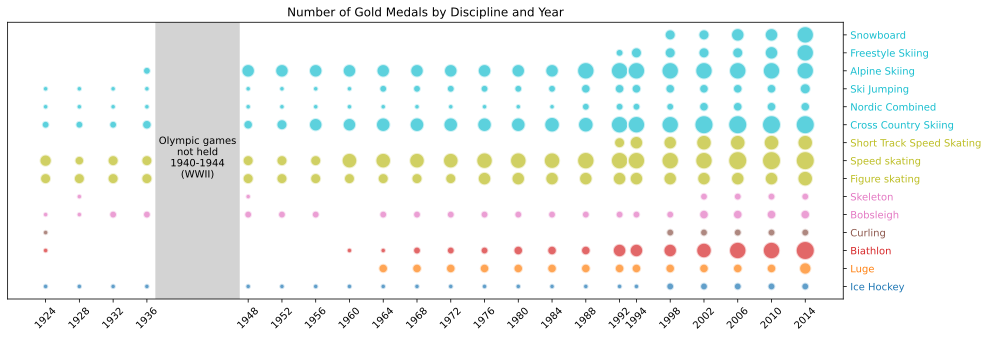

In [57]:
import matplotlib.patches as patches

# Get number of disciplines per sport and sort sports by number of disciplines
disciplines_per_sport = gold_medal_counts.groupby('Sport')['Discipline'].nunique()
sorted_sports = disciplines_per_sport.sort_values(ascending=False).index
sorted_sports = sorted_sports[::-1]

# Define the base color palette for sports and assign colors to each sport
base_colors = plt.colormaps['tab10'].resampled(len(sorted_sports))
sorted_sport_base_color_map = {sport: base_colors(i) for i, sport in enumerate(sorted_sports)}

# Create a new order for disciplines based on the sorted sports
sorted_discipline_order = [discipline for sport in sorted_sports 
                           for discipline in gold_medal_counts[gold_medal_counts['Sport'] == sport]['Discipline'].unique()]

# Create mappings for discipline indices and colors based on the sorted sport order
discipline_index_map = {discipline: i for i, discipline in enumerate(sorted_discipline_order)}
discipline_colors = {discipline: sorted_sport_base_color_map[gold_medal_counts[gold_medal_counts['Discipline'] == discipline]['Sport'].iloc[0]]
                     for discipline in sorted_discipline_order}

# Plotting the bubble chart with custom discipline order based on sport's discipline count
fig, ax = plt.subplots(figsize=(15, 5))

for discipline, data in gold_medal_counts.groupby('Discipline'):
    ax.scatter(
        data['Year'], 
        [discipline_index_map[discipline]] * len(data), 
        s=data['Gold Medals'] * 30,  # Bubble size based on number of gold medals
        color=discipline_colors[discipline], 
        label=discipline, 
        alpha=0.7, 
        edgecolors='w', 
        linewidth=2
    )

# Get the current axis limits
y_min, y_max = ax.get_ylim()

# box position and dimensions
box_x, box_y = 1937, y_min
box_width, box_height = 10, y_max +1

# Create a Rectangle patch
rect = patches.Rectangle((box_x, box_y), box_width, box_height, 
                         edgecolor='none', facecolor='lightgray')
ax.add_patch(rect)

# Add text annotation inside the box
plt.text(box_x + box_width/2, box_y + box_height/2, 
         'Olympic games\nnot held\n1940-1944\n(WWII)', 
         fontsize=10, ha='center', va='center', 
         color='black')

# Formatting plot
plt.title('Number of Gold Medals by Discipline and Year')
ax.yaxis.tick_right()
plt.yticks(range(len(sorted_discipline_order)), sorted_discipline_order)

# custom y tick colors
y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    discipline = label.get_text()
    sport = gold_medal_counts[gold_medal_counts['Discipline'] == discipline]['Sport'].iloc[0]
    label.set_color(sorted_sport_base_color_map[sport])

plt.xticks(gold_medal_counts['Year'].unique(), rotation=45)
plt.show()


# Part 2: Parallel Coordinates

We're back to the familiar Utah Avalanche Center data set for this assignment. Recreate the parallel coordinates chart below using Matplotlib, given the following requirements:

- Subset the data to avalanches caused by skiers in Salt Lake between 2015 and today.
- Highlight (e.g., with another color) avalanches with casualties (i.e. anyone injured, killed, or buried).
- Add a custom legend explaining the highlighting.
- Each axis should range from the minimum to the maximum value of the corresponding variable in the data.

![A parralel coordinates plot of avalance data with fatalities highlighted.](pc.svg)

Hints you may find useful:
- Drop rows that have NaN values in the columns you want to plot.
- Matplotlib's `.twinx()` function is useful to create subfigures that share the same x-axis.
- Note that the ranges of variables are very different. For the lines to fit onto the same chart, all variables should be *normalized* to the range of one variable (for example, if you choose the leftmost variable---year---to be the reference, all other variables should be normalized to range between 2015 and 2023).
- Make sure you first draw the axes, and only then normalize variables to the reference, and then draw.
- You may find it useful to loop over all observations (rows) and `.plot()` each line individually.
- Note that since we are plotting each line individually, matplotlib will not generate a legend. Refer to [the documentation](https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html. ) for guidance on how to create a custom legend.

In [58]:
# Keep this cell

avy_df = pd.read_csv('./avalanches.csv')

# Clean dates and elevation
avy_df['Date'] = pd.to_datetime(avy_df['Date'])
avy_df['Year'] = avy_df['Date'].dt.year.astype('Int64')
avy_df['Month'] = avy_df['Date'].dt.month.astype('Int64')
avy_df['Elevation_Feet'] = pd.to_numeric(avy_df['Elevation'].str.replace('\'', '').str.replace(',', ''))
avy_df['Width_Feet'] = pd.to_numeric(avy_df['Width'].str.replace('\'', '').str.replace(',', ''))
avy_df['Vertical_Feet'] = pd.to_numeric(avy_df['Vertical'].str.replace('\'', '').str.replace(',', ''))

def CleanInchesFeet(x):

    if x!=x: return x

    number = pd.to_numeric(x[:-1].replace(',', ''))
    unit = x[-1]

    if unit == '\"':
        return number
    elif unit == '\'':
        return number*12
    else:
        return float('NaN')
    
avy_df['Depth_Inches'] = avy_df['Depth'].map(lambda x: CleanInchesFeet(x))

# Filter out null dates and incomplete years
avy_df = avy_df[avy_df['Date']==avy_df['Date']]
avy_df = avy_df[avy_df['Year'] > 2015]

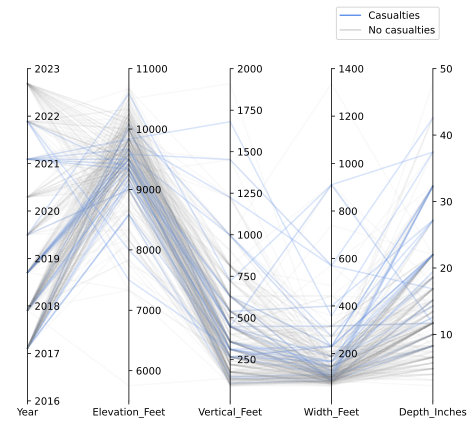

In [59]:
import numpy as np
import matplotlib.lines as mlines

# Subset data for avalanches caused by skiers in Salt Lake
salt_lake_skiers_df = avy_df[(avy_df['Region'] == 'Salt Lake') & (avy_df['Trigger'] == 'Skier')]

# Drop rows with NaN values in relevant columns (Year, Elevation_Feet, Width_Feet, Vertical_Feet, Depth_Inches)
salt_lake_skiers_df = salt_lake_skiers_df.dropna(subset=['Year', 'Elevation_Feet', 'Width_Feet', 'Vertical_Feet', 'Depth_Inches'])

# convert year to int
salt_lake_skiers_df['Year'] = salt_lake_skiers_df['Year'].astype(int)

# fill NaN values in casualties columns with 0
casualties_columns = ['Buried - Partly', 'Buried - Fully', 'Killed', 'Injured']
salt_lake_skiers_df[casualties_columns] = salt_lake_skiers_df[casualties_columns].fillna(0)

# Adding a "Casualties" column based on avalanches with casualties
salt_lake_skiers_df['Casualties'] = (
    salt_lake_skiers_df['Buried - Partly'] + 
    salt_lake_skiers_df['Buried - Fully'] + 
    salt_lake_skiers_df['Killed'] + 
    salt_lake_skiers_df['Injured']
)

# Apply lambda function to create binary column: 1 if casualties exist, 0 otherwise
salt_lake_skiers_df['Casualties'] = salt_lake_skiers_df['Casualties'].apply(lambda x: 1 if x > 0 else 0)

# Normalize each column to the range [2015, 2023]
def normalize(series, new_min=2015, new_max=2023):
    return (series - series.min()) / (series.max() - series.min()) * (new_max - new_min) + new_min

columns_to_normalize= ['Elevation_Feet', 'Width_Feet', 'Vertical_Feet', 'Depth_Inches']
normalized_df = salt_lake_skiers_df[columns_to_normalize].apply(normalize)

# add year to the normalized dataframe and reorder columns
normalized_df['Year'] = salt_lake_skiers_df['Year']
normalized_df = normalized_df[['Year', 'Elevation_Feet', 'Vertical_Feet', 'Width_Feet', 'Depth_Inches']]
columns_to_plot = ['Year', 'Elevation_Feet', 'Vertical_Feet', 'Width_Feet', 'Depth_Inches']

# Define the criteria for highlighting (avalanches with casualties, anyone buried, killed, or injured)
highlight_mask = (
    (salt_lake_skiers_df['Buried - Partly'] > 0) |
    (salt_lake_skiers_df['Buried - Fully'] > 0) |
    (salt_lake_skiers_df['Killed'] > 0) |
    (salt_lake_skiers_df['Injured'] > 0)
)

# Resetting the index of both the normalized DataFrame and highlight mask for consistency
normalized_df = normalized_df.reset_index(drop=True)
highlight_mask = highlight_mask.reset_index(drop=True)

# Plot the parallel coordinates chart
plt.figure(figsize=(8, 6))

# Plot each line for the normalized data
for i, row in normalized_df.iterrows():
    if highlight_mask.iloc[i]:
        plt.plot(range(len(columns_to_plot)), row, color='cornflowerblue', alpha=0.25)
    else:
        plt.plot(range(len(columns_to_plot)), row, color='grey', alpha=0.05)

# Manually creating the legend
casualties_line = mlines.Line2D([], [], color='cornflowerblue', label='Casualties')
no_casualties_line = mlines.Line2D([], [], color='lightgrey', label='No casualties')
plt.legend(handles=[casualties_line, no_casualties_line], loc='upper right', bbox_to_anchor=(.98, 1.2))

# Remove borders for the main plot (ax)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Disable y-ticks on the main plot (ax)
ax.set_yticks([])

# Align x-tick labels with the axes
xtick_labels = ['Year', 'Elevation_Feet', 'Vertical_Feet', 'Width_Feet', 'Depth_Inches']
plt.xticks(range(len(columns_to_plot)), xtick_labels, ha='center')

# Set the vertical alignment of the labels
for label in ax.get_xticklabels():
    label.set_verticalalignment('top')

# Year: 2016-2023
year_ticks = np.arange(2016, 2024, 1)  # Create an array of ticks from 2016 to 2023
ax_year = ax.twinx()  # Create a new axis for Year
ax_year.spines['right'].set_position(('axes', 1 / (len(columns_to_plot) + 17)))  # Position the first axis
ax_year.set_ylim([2016, 2023])  # Set the limits to match the year range
ax_year.set_yticks(year_ticks)  # Set y-ticks for Year
ax_year.set_yticklabels(year_ticks)  # Set the labels
ax_year.spines['top'].set_visible(False)
ax_year.spines['bottom'].set_visible(False)
ax_year.spines['left'].set_visible(False)

# Elevation_Feet: 6000-11000 incrementing by 1000
elevation_ticks = np.arange(6000, 11001, 1000)
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1 / (len(columns_to_plot) - 1.335)))  # Position the second axis
ax2.set_yticks(np.linspace(1000, 11000, len(elevation_ticks)))
ax2.set_yticklabels(elevation_ticks)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Vertical_Feet: 250-2000 incrementing by 250
vertical_ticks = np.arange(250, 2001, 250)
ax3 = ax.twinx()
ax3.spines['right'].set_position(('axes', 2 / (len(columns_to_plot) - 1)))  # Position the third axis
ax3.set_yticks(np.linspace(250, 2000, len(vertical_ticks)))
ax3.set_yticklabels(vertical_ticks)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

# Width_Feet: 200-1400 incrementing by 200
width_ticks = np.arange(200, 1401, 200)
ax4 = ax.twinx()
ax4.spines['right'].set_position(('axes', 3 / (len(columns_to_plot) - .875)))  # Position the fourth axis
ax4.set_yticks(np.linspace(200, 1400, len(width_ticks)))
ax4.set_yticklabels(width_ticks)
ax4.spines['top'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

# Depth_Inches: 10-50 incrementing by 10
depth_ticks = np.arange(10, 51, 10)
ax5 = ax.twinx()
ax5.spines['right'].set_position(('axes', 4 / (len(columns_to_plot) - .81)))  # Position the fifth axis
ax5.set_yticks(np.linspace(10, 50, len(depth_ticks)))
ax5.set_yticklabels(depth_ticks)
ax5.spines['top'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

plt.show()

## Part 3: Scatterplot Matrix

Use seaborn to show a scaterplott matrix of the data you used in Part 2. Make the dots transparent to see which areas are heavily overplotted. 

Hints: 
 * this is one line of code.
 * showing a histogram in the diagonals (instead of a KDE plot) gets around a bug that occurs when using a KDE plot with this dataset

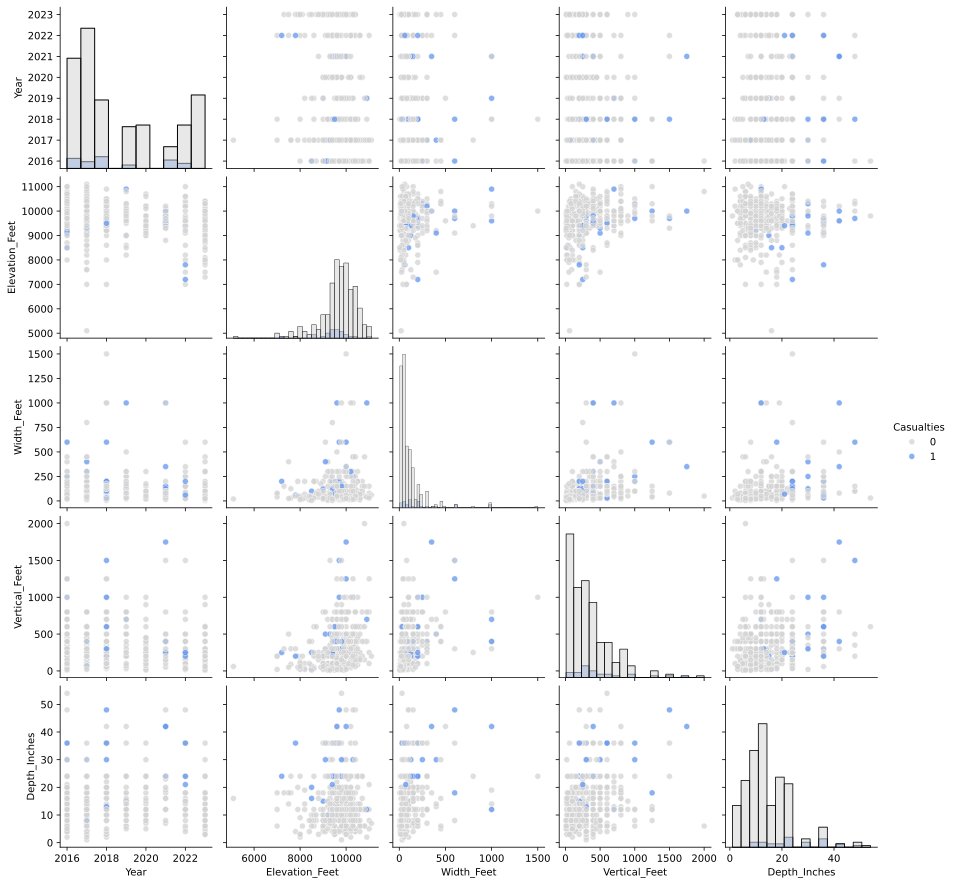

In [77]:
import seaborn as sns

# Create scatterplot matrix
sns.pairplot(salt_lake_skiers_df[['Year', 'Elevation_Feet', 'Width_Feet', 'Vertical_Feet', 'Depth_Inches', 'Casualties']], 
             diag_kind='hist', 
             plot_kws={'alpha': 0.75}, 
             hue='Casualties',
             palette={0: 'lightgrey', 1: 'cornflowerblue'})

## Part 4: Analysis and Comparison

* Analyze the data; under which conditions do casualties occur?
* Compare the scatterplot matrix with the PCP plot. Do you see different patterns in the visualization for this datasets? What are the strengths and weaknesses of each plot? 
  

# Grading Scheme

Part 1: 40%  
Part 2: 40%  
Part 3: 10%  
Part 4: 10%